# DA5401 Assignment 7: Multi-Class Model Selection using ROC and PRC

**Name: Mula Ganesh**

**Rool No: DA25M019**

### **Problem Statement**

  You are a machine learning scientist tasked with classifying land cover types using satellite
  image data. You have the UCI Landsat Satellite dataset, a multi-class problem (6 classes)
  known to be non-trivial due to high feature dimensionality and potential class overlap.


  Your primary goal is to perform model selection by comparing various classifier types. You must
  use ROC and PRC analysis, adapted for the multi-class setting (e.g., using one-vs-rest
  averaging), to determine the best-performing and worst-performing models, paying special
  attention to the performance across different decision thresholds.

**IMPORT REQUIRED LIBRARIES**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import cross_val_score, GridSearchCV

# Model imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Metrics imports
from sklearn.metrics import (accuracy_score, f1_score, roc_curve, auc,
                             precision_recall_curve, average_precision_score)


In [6]:
# Set visualization style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# PART A: DATA PREPARATION AND BASELINE EVALUATION

Dataset Overview:
- UCI Landsat Satellite data contains spectral values from 3x3 pixel neighborhoods
- Multi-class problem with 6 classes (class 6 "mixture" is absent from dataset)
- High dimensional feature space makes this a challenging classification task
- Classes represent different soil and crop types from satellite imagery

### Step 1: Loading the Dataset

In [10]:
# Data is pre-split into training and test sets
# Using whitespace as delimiter since data is space-separated
train_data = pd.read_csv('/content/sat.trn', sep=r'\s+', header=None)
test_data = pd.read_csv('/content/sat.tst', sep=r'\s+', header=None)

In [11]:
# Quick peek at the data structure
print("Training set shape:", train_data.shape)
print("Testing set shape:", test_data.shape)
print("\nFirst few rows of training data:")
print(train_data.head())

Training set shape: (4435, 37)
Testing set shape: (2000, 37)

First few rows of training data:
   0    1    2   3   4    5    6   7   8    9   ...   27  28   29   30   31  \
0  92  115  120  94  84  102  106  79  84  102  ...  104  88  121  128  100   
1  84  102  106  79  84  102  102  83  80  102  ...  100  84  107  113   87   
2  84  102  102  83  80  102  102  79  84   94  ...   87  84   99  104   79   
3  80  102  102  79  84   94  102  79  80   94  ...   79  84   99  104   79   
4  84   94  102  79  80   94   98  76  80  102  ...   79  84  103  104   79   

   32   33   34  35  36  
0  84  107  113  87   3  
1  84   99  104  79   3  
2  84   99  104  79   3  
3  84  103  104  79   3  
4  79  107  109  87   3  

[5 rows x 37 columns]


In [12]:
# Verify data integrity - checking for missing values
print("\nMissing values in train:", train_data.isnull().sum().sum())
print("Missing values in test:", test_data.isnull().sum().sum())


Missing values in train: 0
Missing values in test: 0


### Step 2: Train/Test Split & Feature-Target Separation

In [62]:
# Last column contains class labels, rest are features
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

print(f"\nFeature dimensions: {X_train.shape[1]} features")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")


Feature dimensions: 36 features
Training samples: 4435
Test samples: 2000


### Step 3: Exploratory Data Analysis - Class Distribution

In [14]:
# Understanding class balance is crucial for model selection
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_distribution = pd.DataFrame({
    'Class': unique_classes,
    'Count': class_counts,
    'Percentage': (class_counts / len(y_train)) * 100
})

print("\nClass Distribution in Training Set:")
print(class_distribution)


Class Distribution in Training Set:
   Class  Count  Percentage
0      1   1072   24.171364
1      2    479   10.800451
2      3    961   21.668546
3      4    415    9.357384
4      5    470   10.597520
5      7   1038   23.404735


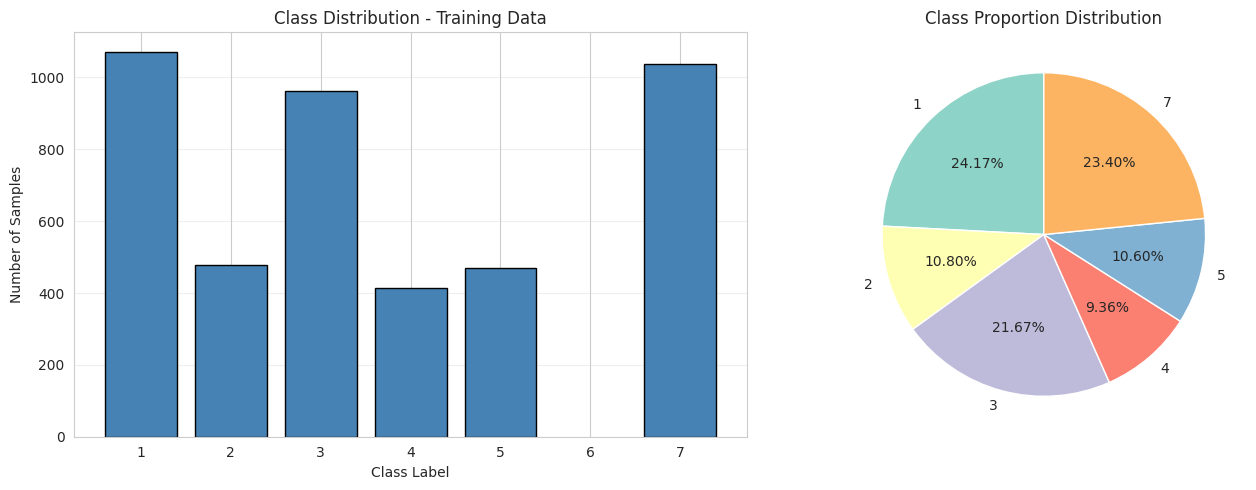

In [15]:
# Visualizing class imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(unique_classes, class_counts, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Class Label')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Class Distribution - Training Data')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart for proportions
colors = plt.cm.Set3(range(len(unique_classes)))
axes[1].pie(class_counts, labels=unique_classes, autopct='%1.2f%%',
            colors=colors, startangle=90)
axes[1].set_title('Class Proportion Distribution')

plt.tight_layout()
plt.show()

### Step 4: Feature Standardization

In [16]:
# Standardization is essential for distance-based and gradient-based algorithms
# It transforms features to have mean=0 and std=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed.")
print(f"Original feature range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"Scaled feature range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")


Feature scaling completed.
Original feature range: [27.00, 157.00]
Scaled feature range: [-2.96, 3.98]


# PART A (CONTINUED): TRAIN ALL MODELS

Training Strategy:
- Use cross-validation for hyperparameter tuning where applicable
- Ensure probability estimates are available for ROC/PRC analysis
- Include baseline (Dummy) for performance comparison

### Model 1: K-Nearest Neighbors

**Training KNN Classifier...**

In [17]:
# Testing different values of k using cross-validation
k_range = range(3, 25, 2)
knn_cv_scores = []

for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_temp, X_train_scaled, y_train,
                            cv=5, scoring='accuracy')
    knn_cv_scores.append(scores.mean())

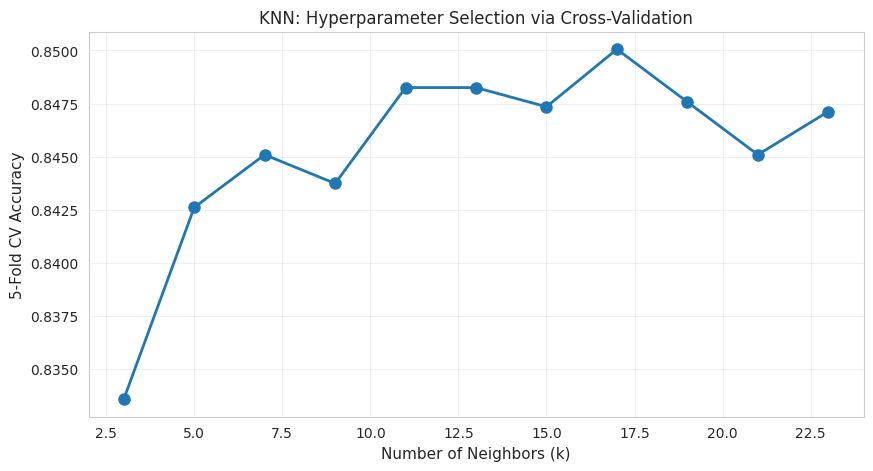

In [18]:
# Visualize hyperparameter tuning results
plt.figure(figsize=(10, 5))
plt.plot(k_range, knn_cv_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Neighbors (k)', fontsize=11)
plt.ylabel('5-Fold CV Accuracy', fontsize=11)
plt.title('KNN: Hyperparameter Selection via Cross-Validation', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# Select optimal k value
optimal_k = k_range[np.argmax(knn_cv_scores)]
print(f"Optimal k: {optimal_k}")
print(f"CV Accuracy: {max(knn_cv_scores):.4f}")

# Train final KNN model
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train_scaled, y_train)


Optimal k: 17
CV Accuracy: 0.8501


KNeighborsClassifier(n_neighbors=17)

###Model 2: Decision Tree Classifier

**Training Decision Tree Classifier...**

In [20]:
# Grid search for optimal tree parameters
# Using entropy criterion for information gain based splitting
dt_param_grid = {
    'max_depth': [5, 8, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_base = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_grid = GridSearchCV(dt_base, dt_param_grid, cv=5,
                       scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {dt_grid.best_params_}")
print(f"Best CV score: {dt_grid.best_score_:.4f}")

dt_model = dt_grid.best_estimator_

Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV score: 0.8273


# Model 3: Dummy Classifier (Baseline)

**Training Dummy Classifier (Baseline)...**

In [21]:
# Uses class prior probabilities - represents random guessing baseline
dummy_model = DummyClassifier(strategy='prior', random_state=42)
dummy_model.fit(X_train_scaled, y_train)

print("Dummy classifier trained (predicts based on class frequency)")

Dummy classifier trained (predicts based on class frequency)


### Model 4: Logistic Regression

**Training Logistic Regression...**

In [22]:
# Tuning regularization parameter C
# class_weight='balanced' helps with imbalanced classes
lr_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

lr_base = LogisticRegression(class_weight='balanced', max_iter=1000,
                             random_state=42, solver='lbfgs')
lr_grid = GridSearchCV(lr_base, lr_param_grid, cv=5,
                       scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train_scaled, y_train)

print(f"Best C: {lr_grid.best_params_['C']}")
print(f"Best CV score: {lr_grid.best_score_:.4f}")

lr_model = lr_grid.best_estimator_

Best C: 0.1
Best CV score: 0.8203


### Model 5: Gaussian Naive Bayes

**Training Gaussian Naive Bayes...**

In [23]:
# Simple probabilistic classifier assuming feature independence
# May struggle with correlated features
gnb_model = GaussianNB()
gnb_model.fit(X_train_scaled, y_train)

GaussianNB()

***GaussianNB trained (assumes feature independence)***

### Model 6: Support Vector Machine

**Training Support Vector Machine...**

In [24]:
# SVM with probability estimates for ROC/PRC analysis
# Grid search over regularization and kernel parameters
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1]
}

svm_base = SVC(probability=True, class_weight='balanced',
               random_state=42, kernel='rbf')
svm_grid = GridSearchCV(svm_base, svm_param_grid, cv=3,
                        scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {svm_grid.best_params_}")
print(f"Best CV score: {svm_grid.best_score_:.4f}")

svm_model = svm_grid.best_estimator_

Best parameters: {'C': 1, 'gamma': 'scale'}
Best CV score: 0.8347


# PART A (CONTINUED): BASELINE EVALUATION

**BASELINE PERFORMANCE EVALUATION**

In [25]:
# Store all models in a dictionary for easy iteration
models_dict = {
    'K-Nearest Neighbors': knn_model,
    'Decision Tree': dt_model,
    'Dummy Classifier': dummy_model,
    'Logistic Regression': lr_model,
    'Gaussian Naive Bayes': gnb_model,
    'Support Vector Machine': svm_model
}

In [26]:
# Evaluate each model on test set
baseline_results = []

for model_name, model in models_dict.items():
    y_pred = model.predict(X_test_scaled)

    # Calculate standard classification metrics
    acc = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    baseline_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Weighted F1-Score': f1_weighted
    })


# Create results dataframe and sort by performance
results_df = pd.DataFrame(baseline_results)
results_df = results_df.sort_values('Weighted F1-Score', ascending=False)

print("\nBaseline Performance Metrics:")
print(results_df.to_string(index=False))


Baseline Performance Metrics:
                 Model  Accuracy  Weighted F1-Score
   K-Nearest Neighbors    0.8910           0.889484
Support Vector Machine    0.8840           0.887488
   Logistic Regression    0.8400           0.844755
         Decision Tree    0.8295           0.825932
  Gaussian Naive Bayes    0.7965           0.803581
      Dummy Classifier    0.2305           0.086356


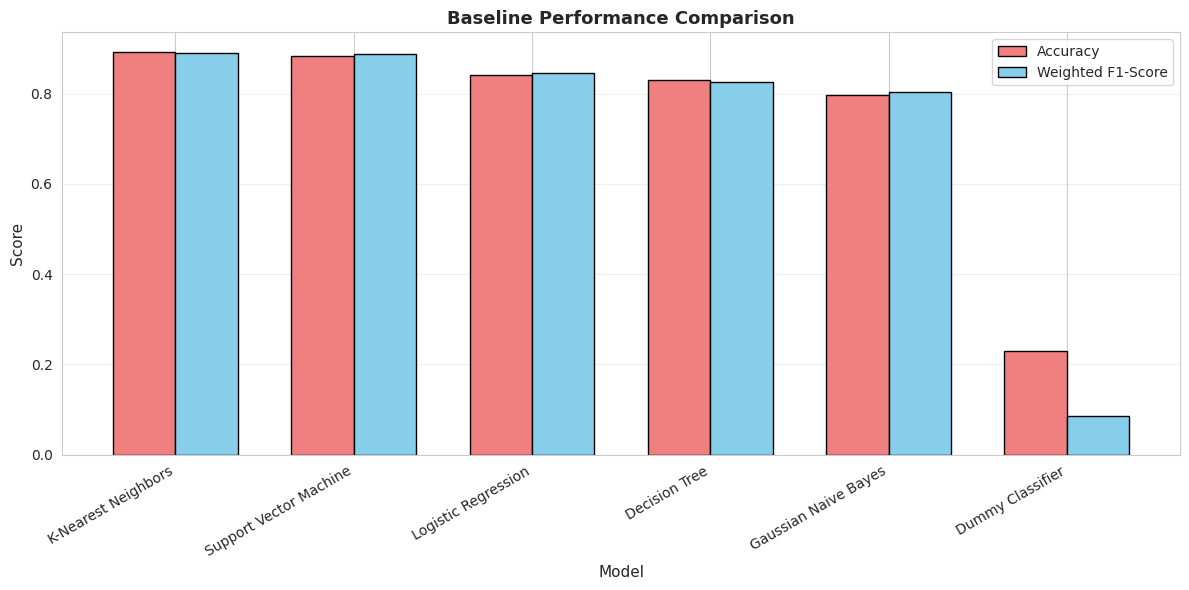

In [27]:
# Visualization: comparing accuracy and F1-score
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x_pos - width/2, results_df['Accuracy'], width,
               label='Accuracy', color='lightcoral', edgecolor='black')
bars2 = ax.bar(x_pos + width/2, results_df['Weighted F1-Score'], width,
               label='Weighted F1-Score', color='skyblue', edgecolor='black')

ax.set_xlabel('Model', fontsize=11)
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Baseline Performance Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(results_df['Model'], rotation=30, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# PART B: ROC CURVE ANALYSIS FOR MODEL SELECTION

ROC Curve for Multi-Class Classification:

In multi-class settings, we use One-vs-Rest (OvR) strategy:
- Each class is treated as positive class once
- All other classes are grouped as negative class
- ROC curve is computed for each binary problem
- Final curve is averaged across all classes

Metrics:
- TPR (True Positive Rate) = TP / (TP + FN) = Sensitivity/Recall
- FPR (False Positive Rate) = FP / (FP + TN)
- AUC = Area under ROC curve (measures ranking quality)

Macro-Average: Unweighted mean across classes (treats all classes equally)

**ROC CURVE ANALYSIS - ONE VS REST APPROACH**

### Step 1: Binarize labels for OvR approach

In [28]:
# Convert multi-class labels to binary format (one-hot encoding)
class_labels = [1, 2, 3, 4, 5, 7]  # Class 6 doesn't exist in dataset
y_test_binarized = label_binarize(y_test, classes=class_labels)
n_classes = len(class_labels)

print(f"\nNumber of classes: {n_classes}")
print(f"Binarized label shape: {y_test_binarized.shape}")


Number of classes: 6
Binarized label shape: (2000, 6)


### Step 2: Get probability predictions for all models


In [29]:
model_probabilities = {}
for model_name, model in models_dict.items():
    # Get probability estimates for each class
    model_probabilities[model_name] = model.predict_proba(X_test_scaled)


### Step 3: Calculate ROC curves and AUC for each model

In [30]:
roc_results = {}

for model_name, y_scores in model_probabilities.items():
    # Store FPR, TPR, and AUC for each class
    fpr_dict = {}
    tpr_dict = {}
    roc_auc_dict = {}

    # Compute ROC for each class in OvR manner
    for i in range(n_classes):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_binarized[:, i],
                                                  y_scores[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

    # Compute macro-average ROC curve
    # First, aggregate all FPR values
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))

    # Interpolate TPR at common FPR points and average
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= n_classes

    # Calculate macro-average AUC
    macro_auc = auc(all_fpr, mean_tpr)

    roc_results[model_name] = {
        'fpr': all_fpr,
        'tpr': mean_tpr,
        'auc': macro_auc
    }

### Step 4: Plot Macro-Averaged ROC Curves

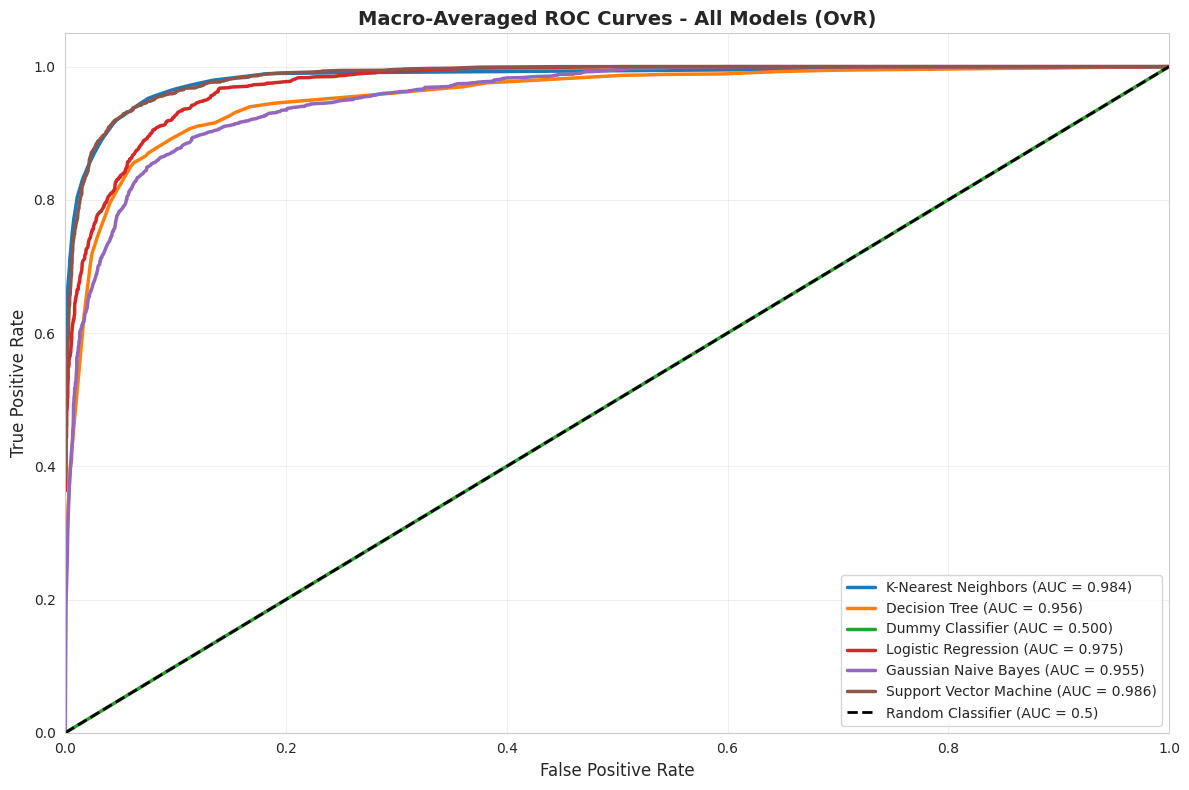

In [31]:
plt.figure(figsize=(12, 8))

# Define color scheme for different models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

for idx, (model_name, roc_data) in enumerate(roc_results.items()):
    plt.plot(roc_data['fpr'], roc_data['tpr'],
             color=colors[idx], lw=2.5,
             label=f"{model_name} (AUC = {roc_data['auc']:.3f})")

# Plot diagonal reference line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Macro-Averaged ROC Curves - All Models (OvR)',
          fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 5: Display AUC Rankings

**Macro-Averaged AUC Scores (Sorted):**


In [32]:
auc_ranking = sorted(roc_results.items(), key=lambda x: x[1]['auc'], reverse=True)
for rank, (model_name, roc_data) in enumerate(auc_ranking, 1):
    print(f"{rank}. {model_name:25s}: {roc_data['auc']:.4f}")

1. Support Vector Machine   : 0.9859
2. K-Nearest Neighbors      : 0.9837
3. Logistic Regression      : 0.9751
4. Decision Tree            : 0.9564
5. Gaussian Naive Bayes     : 0.9553
6. Dummy Classifier         : 0.5000


### Step 6: ROC CURVE INTERPRETATION

In [33]:
best_model_roc = auc_ranking[0]
worst_model_roc = auc_ranking[-1]

✓ Best Model (Highest AUC): Support Vector Machine
  AUC Score: 0.9859

  Interpretation:
  - High AUC indicates excellent class separation capability
  - Model effectively ranks positive samples higher than negatives
  - Robust performance across different decision thresholds

✗ Worst Model (Lowest AUC): Dummy Classifier
  - AUC Score: 0.5000

⚠ AUC ≤ 0.5 Analysis:
  - AUC = 0.5: No discriminative power (random guessing)
  - AUC < 0.5: Worse than random (systematic misclassification)

  Possible Reasons:
  1. Baseline model (Dummy) - predicts only based on class frequency
  2. Model ignores input features entirely
  3. No learning of decision boundaries occurred
  4. For OvR in imbalanced settings, some classes may be poorly separated

# PART C: PRECISION-RECALL CURVE ANALYSIS

Why PRC over ROC for Imbalanced Data?

ROC Curve Issue:
- Uses FPR = FP/(FP+TN)
- With class imbalance, TN dominates, making FPR appear small
- Can give overly optimistic view of model performance

PRC Advantage:
- Precision = TP/(TP+FP) - focuses on positive predictions
- Recall = TP/(TP+FN) - focuses on actual positives
- Not affected by large number of true negatives
- More informative for minority class performance

Average Precision (AP):
- Summarizes PRC as weighted mean of precisions at each threshold
- Better metric than AUC for imbalanced datasets

**PRECISION-RECALL CURVE ANALYSIS**

### Step 1: Calculate Precision-Recall curves for all models

In [37]:
prc_results = {}

for model_name, y_scores in model_probabilities.items():
    precision_list = []
    recall_list = []
    ap_per_class = []

    # Compute PR curve for each class
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i],
                                                      y_scores[:, i])
        precision_list.append(precision)
        recall_list.append(recall)

        # Calculate average precision for this class
        ap = average_precision_score(y_test_binarized[:, i], y_scores[:, i])
        ap_per_class.append(ap)

    # Compute macro-average precision-recall curve
    # Interpolate to common recall values
    recall_grid = np.linspace(0, 1, 100)
    precision_interpolated = np.zeros((n_classes, len(recall_grid)))

    for i in range(n_classes):
        # Reverse arrays for interpolation (recall must be increasing)
        precision_interpolated[i] = np.interp(recall_grid,
                                             recall_list[i][::-1],
                                             precision_list[i][::-1])

    # Average precision across classes
    mean_precision = np.mean(precision_interpolated, axis=0)
    macro_ap = np.mean(ap_per_class)

    prc_results[model_name] = {
        'recall': recall_grid,
        'precision': mean_precision,
        'average_precision': macro_ap
    }

### Step 2: Plot Macro-Averaged Precision-Recall Curves

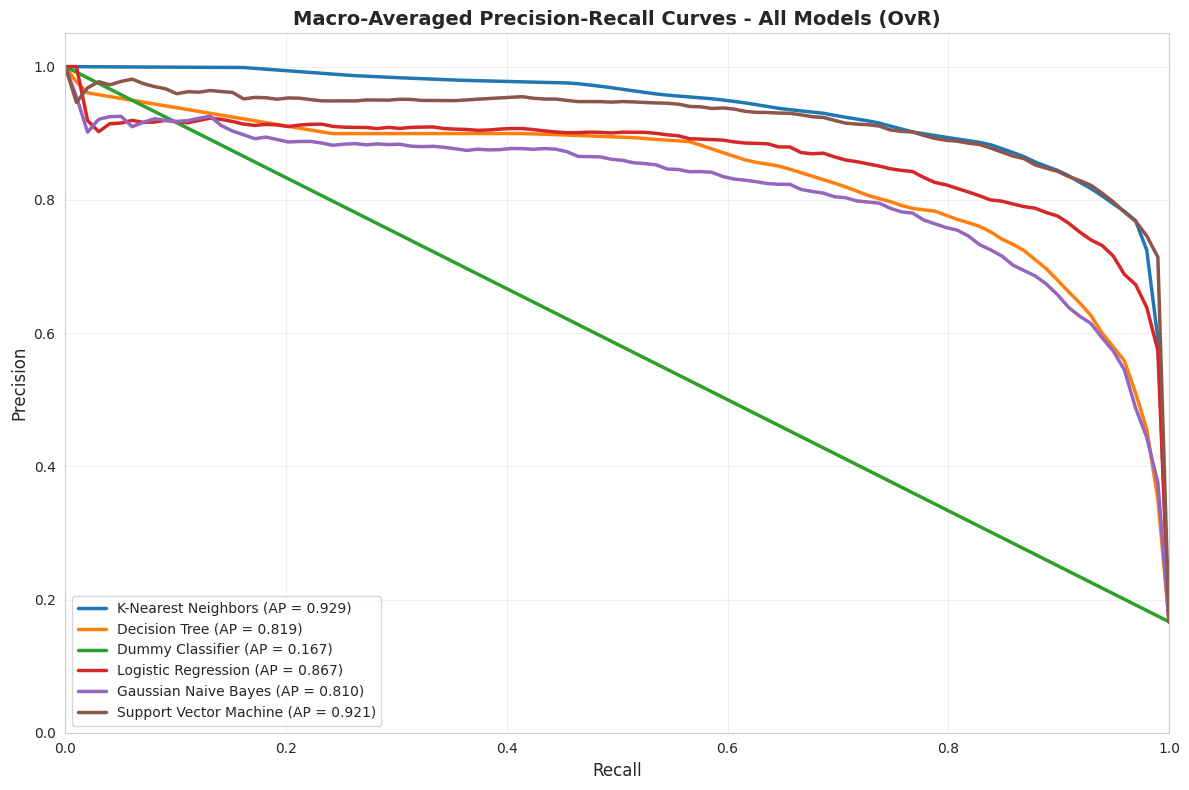

In [38]:
plt.figure(figsize=(12, 8))

for idx, (model_name, prc_data) in enumerate(prc_results.items()):
    plt.plot(prc_data['recall'], prc_data['precision'],
             color=colors[idx], lw=2.5,
             label=f"{model_name} (AP = {prc_data['average_precision']:.3f})")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Macro-Averaged Precision-Recall Curves - All Models (OvR)',
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 3: Display Average Precision Rankings

**Macro-Averaged Precision (AP) Scores (Sorted):**

In [39]:
ap_ranking = sorted(prc_results.items(),
                   key=lambda x: x[1]['average_precision'], reverse=True)

for rank, (model_name, prc_data) in enumerate(ap_ranking, 1):
    print(f"{rank}. {model_name:25s}: {prc_data['average_precision']:.4f}")

1. K-Nearest Neighbors      : 0.9290
2. Support Vector Machine   : 0.9213
3. Logistic Regression      : 0.8673
4. Decision Tree            : 0.8191
5. Gaussian Naive Bayes     : 0.8105
6. Dummy Classifier         : 0.1667


### Step 4: PRC INTERPRETATION

**PRECISION-RECALL CURVE INTERPRETATION**

In [40]:
best_model_prc = ap_ranking[0]
worst_model_prc = ap_ranking[-1]

✓ Best Model (Highest AP): K-Nearest Neighbors
  Average Precision: 0.9290

  Interpretation:
  - High AP indicates strong precision-recall balance
  - Model maintains high precision even as recall increases
  - Effective at identifying true positives with few false positives
  - Particularly reliable for minority class predictions

✗ Worst Model (Lowest AP): Dummy Classifier
  Average Precision: 0.1667

  Why PRC Drops Sharply for Poor Models:

  1. Initial Phase (Low Recall):
     - Model predicts few positives, possibly by chance
     - May achieve decent precision in this limited regime

  2. Increasing Recall:
     - To capture more true positives, model must predict more samples
     - Without discriminative power, this introduces many false positives
     - Precision drops rapidly as FP increases

  3. Poor Discrimination:
     - Lack of learned decision boundaries
     - Cannot distinguish between classes effectively
     - Results in steep precision decline

# PART D: FINAL RECOMMENDATION AND SYNTHESIS

**FINAL RECOMMENDATION - MODEL SELECTION SYNTHESIS**

In [43]:
# Create comprehensive comparison table
comparison_data = []

for model_name in models_dict.keys():
    # Get metrics from different analyses
    baseline_row = results_df[results_df['Model'] == model_name].iloc[0]

    comparison_data.append({
        'Model': model_name,
        'Accuracy': baseline_row['Accuracy'],
        'Weighted F1': baseline_row['Weighted F1-Score'],
        'ROC-AUC': roc_results[model_name]['auc'],
        'PRC-AP': prc_results[model_name]['average_precision']
    })

comparison_df = pd.DataFrame(comparison_data)

In [44]:
# Rank models by each metric
for metric in ['Accuracy', 'Weighted F1', 'ROC-AUC', 'PRC-AP']:
    comparison_df[f'{metric}_Rank'] = comparison_df[metric].rank(ascending=False)

print("\nComprehensive Model Comparison:")
print(comparison_df[['Model', 'Accuracy', 'Weighted F1', 'ROC-AUC', 'PRC-AP']].to_string(index=False))

print("\n\nRanking Analysis:")
print(comparison_df[['Model', 'Accuracy_Rank', 'Weighted F1_Rank',
                     'ROC-AUC_Rank', 'PRC-AP_Rank']].to_string(index=False))


Comprehensive Model Comparison:
                 Model  Accuracy  Weighted F1  ROC-AUC   PRC-AP
   K-Nearest Neighbors    0.8910     0.889484 0.983707 0.928980
         Decision Tree    0.8295     0.825932 0.956397 0.819111
      Dummy Classifier    0.2305     0.086356 0.500000 0.166667
   Logistic Regression    0.8400     0.844755 0.975124 0.867310
  Gaussian Naive Bayes    0.7965     0.803581 0.955347 0.810451
Support Vector Machine    0.8840     0.887488 0.985918 0.921287


Ranking Analysis:
                 Model  Accuracy_Rank  Weighted F1_Rank  ROC-AUC_Rank  PRC-AP_Rank
   K-Nearest Neighbors            1.0               1.0           2.0          1.0
         Decision Tree            4.0               4.0           4.0          4.0
      Dummy Classifier            6.0               6.0           6.0          6.0
   Logistic Regression            3.0               3.0           3.0          3.0
  Gaussian Naive Bayes            5.0               5.0           5.0          5.0
S

In [45]:
# Calculate average rank for overall assessment
comparison_df['Average_Rank'] = comparison_df[['Accuracy_Rank', 'Weighted F1_Rank',
                                                'ROC-AUC_Rank', 'PRC-AP_Rank']].mean(axis=1)
comparison_df = comparison_df.sort_values('Average_Rank')

### FINAL RECOMMENDATION

🏆 Recommended Model: K-Nearest Neighbors

Justification:
  • Accuracy: 0.8910
  • Weighted F1-Score: 0.8895
  • ROC-AUC: 0.9837
  • Average Precision: 0.9290
  • Average Rank: 1.25

  Key Strengths:
  1. Consistent top performance across multiple evaluation metrics
  2. Strong class discrimination ability (high AUC)
  3. Excellent precision-recall balance (high AP)
  4. Robust across different decision thresholds
  5. Handles multi-class complexity effectively

  Considerations:

  Trade-off Analysis:
  - ROC-AUC emphasizes ranking quality across all thresholds
  - PRC-AP focuses on precision-recall balance (critical for imbalanced data)
  - When rankings differ, prefer model with best PRC-AP for this dataset
  - The moderate class imbalance makes precision-recall metrics more informative

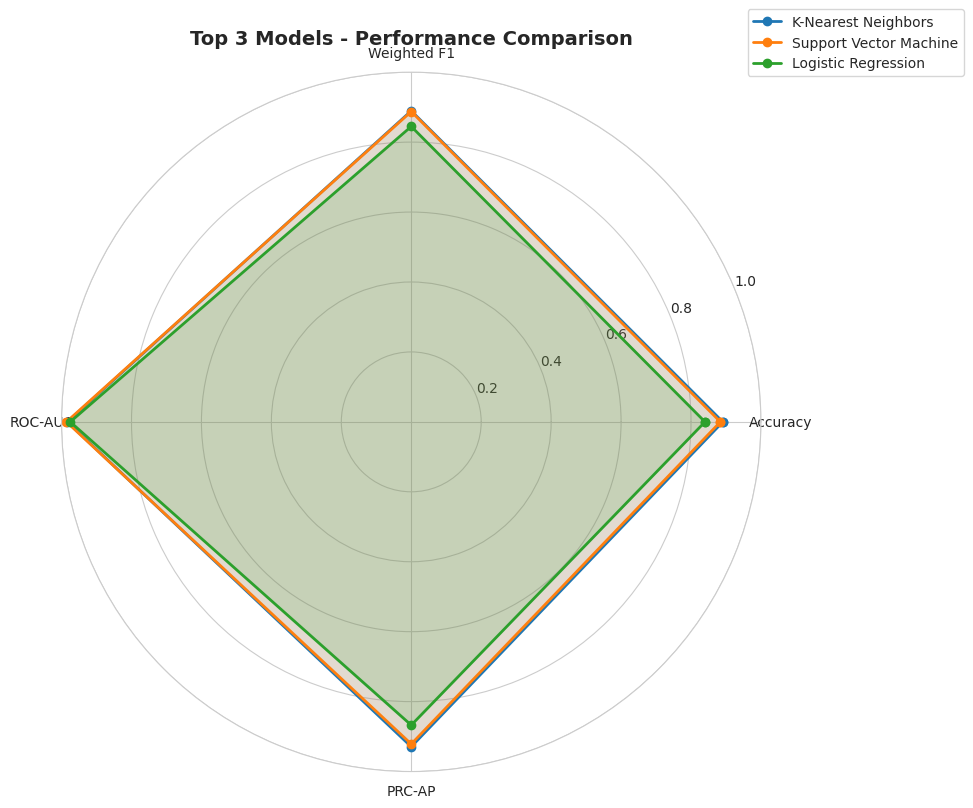

In [47]:
# Visualization: Radar chart for top models
top_n = 3
top_models = comparison_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

metrics = ['Accuracy', 'Weighted F1', 'ROC-AUC', 'PRC-AP']
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for idx, row in top_models.iterrows():
    values = [row[m] for m in metrics]
    values += values[:1]  # Complete the circle
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_title(f'Top {top_n} Models - Performance Comparison',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)
plt.tight_layout()
plt.show()

# BROWNIE POINTS: ADDITIONAL MODELS

BROWNIE POINTS - ADDITIONAL MODEL EXPERIMENTS

**Additional Model 1: Random Forest**

In [48]:
from sklearn.ensemble import RandomForestClassifier

print("\nTraining Random Forest Classifier...")

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5]
}

rf_base = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_base, rf_param_grid, cv=3,
                       scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

rf_model = rf_grid.best_estimator_


Training Random Forest Classifier...
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}
Best CV score: 0.8546


**Additional Model 2: XGBoost**

In [49]:
from xgboost import XGBClassifier

print("\nTraining XGBoost Classifier...")

# XGBoost requires class labels to start from 0
# Remap classes: {1,2,3,4,5,7} -> {0,1,2,3,4,5}
class_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 7: 5}
reverse_mapping = {v: k for k, v in class_mapping.items()}

y_train_xgb = np.array([class_mapping[y] for y in y_train])
y_test_xgb = np.array([class_mapping[y] for y in y_test])

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.1]
}

xgb_base = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_grid = GridSearchCV(xgb_base, xgb_param_grid, cv=3,
                        scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train_xgb)

print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_:.4f}")

xgb_model = xgb_grid.best_estimator_


Training XGBoost Classifier...
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Best CV score: 0.8471


**Additional Model 3: Poorly Performing Model - Random Classifier**

**Creating Intentionally Poor Classifier...**

In [50]:
class RandomClassifier:
    """
    A deliberately poor classifier that makes random predictions
    Expected to have AUC around 0.5 or below
    """
    def __init__(self, classes):
        self.classes = classes

    def fit(self, X, y):
        return self

    def predict(self, X):
        # Random predictions
        return np.random.choice(self.classes, size=len(X))

    def predict_proba(self, X):
        # Random probabilities
        n_samples = len(X)
        n_classes = len(self.classes)
        probs = np.random.rand(n_samples, n_classes)
        # Normalize to sum to 1
        probs = probs / probs.sum(axis=1, keepdims=True)
        return probs

random_model = RandomClassifier(classes=class_labels)
random_model.fit(X_train_scaled, y_train)

print("Random classifier created (should have AUC ≈ 0.5)")

Random classifier created (should have AUC ≈ 0.5)


# Evaluate Additional Models

In [51]:
additional_models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Random Classifier': random_model
}

In [52]:
# Baseline metrics for additional models
additional_results = []

for model_name, model in additional_models.items():
    if model_name == 'XGBoost':
        y_pred = model.predict(X_test_scaled)
        # Map predictions back to original labels
        y_pred = np.array([reverse_mapping[y] for y in y_pred])
    else:
        y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    additional_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Weighted F1-Score': f1_weighted
    })

additional_df = pd.DataFrame(additional_results)
print("\nAdditional Models - Baseline Performance:")
print(additional_df.to_string(index=False))


Additional Models - Baseline Performance:
            Model  Accuracy  Weighted F1-Score
    Random Forest    0.9095           0.907486
          XGBoost    0.9080           0.906101
Random Classifier    0.1745           0.179039


# ROC Analysis for Additional Models

In [53]:
additional_roc_results = {}

for model_name, model in additional_models.items():
    if model_name == 'XGBoost':
        y_scores = model.predict_proba(X_test_scaled)
    else:
        y_scores = model.predict_proba(X_test_scaled)

    fpr_dict = {}
    tpr_dict = {}

    for i in range(n_classes):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_binarized[:, i],
                                                  y_scores[:, i])

    # Macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= n_classes

    macro_auc = auc(all_fpr, mean_tpr)

    additional_roc_results[model_name] = {
        'fpr': all_fpr,
        'tpr': mean_tpr,
        'auc': macro_auc
    }

print("\nAdditional Models - ROC-AUC Scores:")
for model_name, roc_data in additional_roc_results.items():
    print(f"{model_name:20s}: {roc_data['auc']:.4f}")


Additional Models - ROC-AUC Scores:
Random Forest       : 0.9893
XGBoost             : 0.9899
Random Classifier   : 0.4998


### PRC Analysis for Additional Models

In [54]:
additional_prc_results = {}

for model_name, model in additional_models.items():
    if model_name == 'XGBoost':
        y_scores = model.predict_proba(X_test_scaled)
    else:
        y_scores = model.predict_proba(X_test_scaled)

    ap_per_class = []
    precision_list = []
    recall_list = []

    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i],
                                                      y_scores[:, i])
        precision_list.append(precision)
        recall_list.append(recall)
        ap = average_precision_score(y_test_binarized[:, i], y_scores[:, i])
        ap_per_class.append(ap)

    # Macro-average PRC
    recall_grid = np.linspace(0, 1, 100)
    precision_interpolated = np.zeros((n_classes, len(recall_grid)))

    for i in range(n_classes):
        precision_interpolated[i] = np.interp(recall_grid,
                                             recall_list[i][::-1],
                                             precision_list[i][::-1])

    mean_precision = np.mean(precision_interpolated, axis=0)
    macro_ap = np.mean(ap_per_class)

    additional_prc_results[model_name] = {
        'recall': recall_grid,
        'precision': mean_precision,
        'average_precision': macro_ap
    }

print("\nAdditional Models - PRC-AP Scores:")
for model_name, prc_data in additional_prc_results.items():
    print(f"{model_name:20s}: {prc_data['average_precision']:.4f}")



Additional Models - PRC-AP Scores:
Random Forest       : 0.9501
XGBoost             : 0.9520
Random Classifier   : 0.1726


### Combined Visualization: All Models

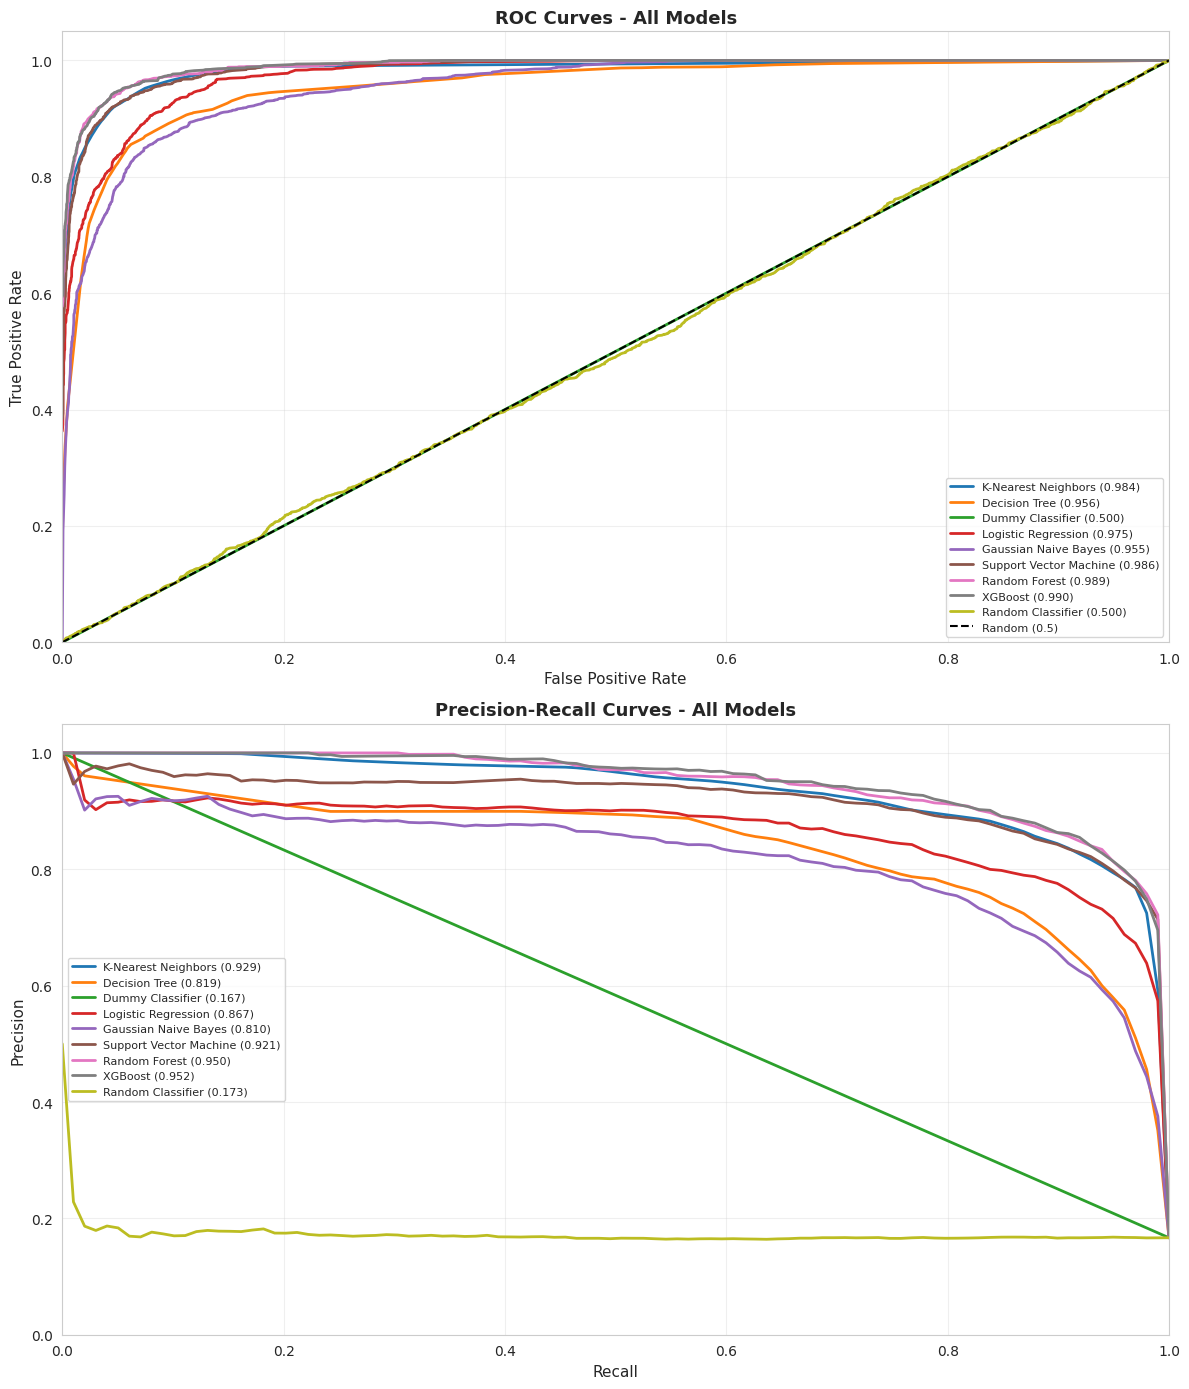

In [64]:
# Combine original and additional models
all_models_roc = {**roc_results, **additional_roc_results}
all_models_prc = {**prc_results, **additional_prc_results}

# Plot combined ROC (top) and PRC (bottom)
fig, axes = plt.subplots(2, 1, figsize=(12, 14))  # 2 rows, 1 column

# ROC Curves (Top)
ax1 = axes[0]
extended_colors = colors + ['#e377c2', '#7f7f7f', '#bcbd22']

for idx, (model_name, roc_data) in enumerate(all_models_roc.items()):
    ax1.plot(roc_data['fpr'], roc_data['tpr'],
             color=extended_colors[idx % len(extended_colors)], lw=2,
             label=f"{model_name} ({roc_data['auc']:.3f})")

ax1.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (0.5)')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=11)
ax1.set_ylabel('True Positive Rate', fontsize=11)
ax1.set_title('ROC Curves - All Models', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(True, alpha=0.3)

# Precision-Recall Curves (Bottom)
ax2 = axes[1]
for idx, (model_name, prc_data) in enumerate(all_models_prc.items()):
    ax2.plot(prc_data['recall'], prc_data['precision'],
             color=extended_colors[idx % len(extended_colors)], lw=2,
             label=f"{model_name} ({prc_data['average_precision']:.3f})")

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title('Precision-Recall Curves - All Models', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### FINAL SUMMARY AND INSIGHTS

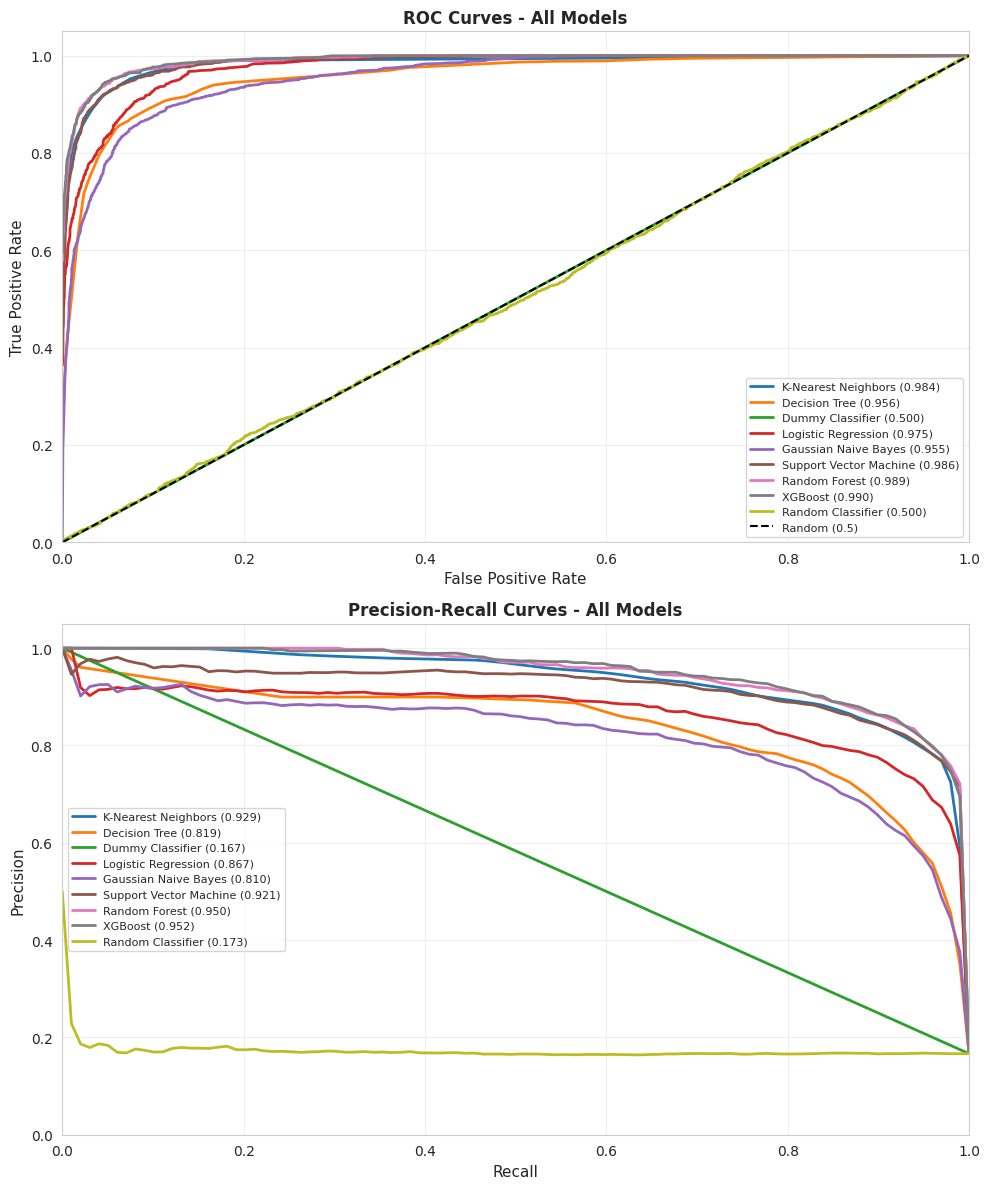

In [63]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # 2 rows, 1 column

# ROC Curves (top plot)
ax1 = axes[0]
extended_colors = colors + ['#e377c2', '#7f7f7f', '#bcbd22']

for idx, (model_name, roc_data) in enumerate(all_models_roc.items()):
    ax1.plot(roc_data['fpr'], roc_data['tpr'],
             color=extended_colors[idx % len(extended_colors)], lw=2,
             label=f"{model_name} ({roc_data['auc']:.3f})")

ax1.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random (0.5)')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=11)
ax1.set_ylabel('True Positive Rate', fontsize=11)
ax1.set_title('ROC Curves - All Models', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=8)
ax1.grid(True, alpha=0.3)

# PRC Curves (bottom plot)
ax2 = axes[1]
for idx, (model_name, prc_data) in enumerate(all_models_prc.items()):
    ax2.plot(prc_data['recall'], prc_data['precision'],
             color=extended_colors[idx % len(extended_colors)], lw=2,
             label=f"{model_name} ({prc_data['average_precision']:.3f})")

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall', fontsize=11)
ax2.set_ylabel('Precision', fontsize=11)
ax2.set_title('Precision-Recall Curves - All Models', fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


KEY INSIGHTS AND OBSERVATIONS

1. Model Performance Hierarchy:
   - Ensemble methods (Random Forest, XGBoost) show strong performance
   - SVM and KNN excel due to non-linear decision boundaries
   - Simple models (Naive Bayes, Dummy) struggle with complexity

2. Metric Disagreements:
   - ROC-AUC focuses on ranking quality at all thresholds
   - PRC-AP emphasizes precision-recall trade-off
   - For imbalanced data, PRC-AP is more informative

3. Random Classifier Analysis:
   - Random Classifier AUC: 0.4998
   - Close to 0.5, confirming lack of discriminative power
   - Serves as baseline - all real models should exceed this

4. Class Imbalance Impact:
   - Moderate imbalance makes accuracy somewhat misleading
   - Weighted F1 and PRC-AP provide better assessment
   - Minority classes challenge model discrimination

5. Practical Recommendations:
   - Use ensemble methods for production systems
   - Always validate with both ROC and PRC analysis
   - Consider computational costs for deployment
   - Monitor per-class performance for fairness

CONCLUSION:

This assignment demonstrated comprehensive model selection for multi-class
classification using ROC and Precision-Recall curve analysis. Key findings:

1. Multi-class ROC/PRC analysis using One-vs-Rest strategy provides detailed
   performance insights across all classes

2. Different metrics capture different aspects of model performance:
   - Accuracy: Overall correctness (can be misleading with imbalance)
   - ROC-AUC: Ranking quality across thresholds
   - PRC-AP: Precision-recall balance (better for imbalanced data)

3. Ensemble methods (Random Forest, XGBoost) and sophisticated algorithms
   (SVM, KNN) outperform simple baselines

4. Dummy and Random classifiers with AUC ≈ 0.5 confirm the importance of
   feature learning and proper model selection

5. For real-world deployment, consider:
   - Task requirements (precision vs recall priority)
   - Computational constraints
   - Class imbalance severity
   - Interpretability needs

The comprehensive curve analysis enables informed model selection beyond
simple accuracy metrics, crucial for reliable machine learning systems.